Representational Similarity Analyses

In [2]:
#@title Load packages
import os, requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [5]:
#@title Data file access
# give google colab access to your drive
#from google.colab import drive
#drive.mount('/content/drive')

wd="/Users/miriam/GoogleDrive/GraduateWork/trainings/Neuromatch Academy/data/"

all_fnames = ['gratings_noisy_GT1_2019_04_08_1.npy', \
          'gratings_static_GT1_2019_04_17_1.npy',\
          'minnie_GT1_2019_04_29_2.npy',\
          'gratings_drifting_GT1_2019_04_12_1.npy',\
          'gratings_local_GT1_2019_04_27_2.npy']
fname_keys = ['noisy', 'static', 'minnie', 'drifting', 'local']


In [6]:
#@title Data loading
# load this mouse's data
dats={}
# which files do you want to load?
idx = [1,2]#range(len(fname_keys))
# load each file and save it in a new array
for ind in idx:
  dats[fname_keys[ind]] = np.load(os.path.join(wd, all_fnames[ind]), allow_pickle=True).item()


In [7]:
from scipy.spatial import distance_matrix
def make_rdm(dat, dist="correlation", return_lowertri=False):
  n_cond = len(dat['istim'])
  stim_order = np.argsort(dat['istim'])
  istim_ordered = dat['istim'][stim_order]
  sresp_ordered = dat['sresp'][:,stim_order]
  if dist=="correlation":
    rdm = 1 - np.corrcoef(sresp_ordered.T)
  elif dist=="euclidean":
    rdm = distance_matrix(sresp_ordered.T, sresp_ordered.T)
  if return_lowertri:
    rdm = rdm[np.tril_indices(len(rdm), k=-1)] # extract the lower triangle
  return rdm, istim_ordered


def make_rdm_func_conn(dat, size=4000, dist="correlation"):
  idx = np.random.choice(range(len(dat['sresp'])), size=size)
  dat_sel = dat['sresp'][idx,:]
  if dist=="correlation":
    rdm = np.corrcoef(dat_sel)
  elif dist=="euclidean":
    rdm = distance_matrix(dat_sel, dat_sel)
  # plot
  plt.figure(figsize=(10,10))
  plt.imshow(rdm_spont_f)
  plt.colorbar()
  plt.clim([0,.04])
  return rdm

In [16]:
#@ RSA
#@ Calculate representational dissimilarity matrices (RDMs)
from matplotlib import pyplot as plt

rdm_static, istim_static = make_rdm(dats['static'])
print(istim_static)

rdm_minnie, istim_minnie = make_rdm(dats['minnie'])
print(istim_minnie)

[6.09159136e-04 7.18638172e-04 2.50309571e-03 ... 6.27388938e+00
 6.27438312e+00 6.28240486e+00]
[6.09159136e-04 7.18638172e-04 2.50309571e-03 ... 6.27388938e+00
 6.27438312e+00 6.28240486e+00]


In [17]:
# subselect stimuli that are in both datasets
stim_intersect, minnie_sel, static_sel = np.intersect1d(istim_minnie, istim_static, return_indices=True)

rdm_static_sel = rdm_static[:, static_sel]
rdm_static_sel = rdm_static_sel[static_sel, :]
rdm_minnie_sel = rdm_minnie[:, minnie_sel]
rdm_minnie_sel = rdm_minnie_sel[minnie_sel, :]

print(rdm_static_sel.shape,rdm_minnie_sel.shape)

(4598, 4598) (4598, 4598)


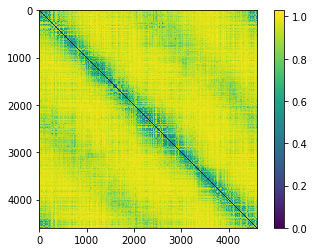

In [18]:
# Static Dissimilarity Matrix
plt.imshow(rdm_static)
plt.colorbar()

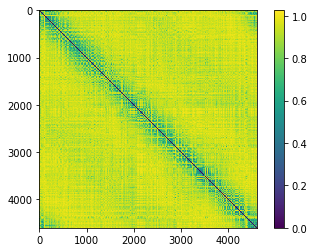

In [19]:
# Minnie Mouse Dissimilarity Matrix
plt.imshow(rdm_minnie)
plt.colorbar()

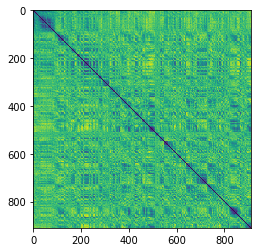

In [20]:
static_spont = dats['static']['u_spont'] @ dats['static']['v_spont']
rdm_spont_static = 1 - np.corrcoef(static_spont.T)
plt.imshow(rdm_spont_static)

In [21]:
# take lower triangles and find correlation coefficient
lt_static_sel = rdm_static_sel[np.tril_indices(len(rdm_static_sel), k=-1)]
lt_minnie_sel = rdm_minnie_sel[np.tril_indices(len(rdm_minnie_sel), k=-1)]
np.corrcoef(lt_static_sel,lt_minnie_sel)[0,1]

0.5443926662310988

Look at correlations between neurons' timeseries

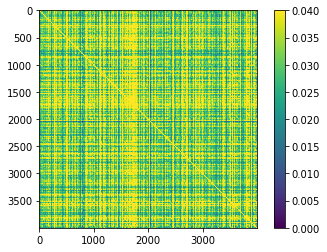

In [42]:

rdm_static_f= make_rdm_func_conn(dats['static'])
plt.imshow(rdm_static_f)
plt.colorbar()
plt.clim([0,.04])

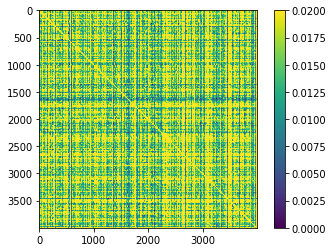

In [43]:

rdm_minnie_f= make_rdm_func_conn(dats['minnie'])
plt.imshow(rdm_minnie_f)
plt.colorbar()
plt.clim([0,.02])

In [ ]:
static_spont = {}
static_spont['sresp'] = dats['static']['u_spont'] @ dats['static']['v_spont']
rdm_spont_f= make_rdm_func_conn(static_spont, 2000)
# plt.figure(figsize=(10,10))
# plt.imshow(rdm_spont_f)
# plt.colorbar()
# plt.clim([0,.04])

Try decoding minnie mouse RDM from static RDM

In [45]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

rdm_static_sel_std = StandardScaler().fit_transform(rdm_static_sel)
rdm_minnie_sel_std = StandardScaler().fit_transform(rdm_minnie_sel)

lm = LinearRegression()
lm.fit(rdm_static_sel_std, stim_intersect)

mlp = MLPRegressor(solver='lbfgs',activation= 'tanh' , alpha=1e-5, hidden_layer_sizes=(20,1), random_state=1, max_iter = 1e4)
mlp.fit(rdm_static_sel_std, stim_intersect)

MLPRegressor(activation='tanh', alpha=1e-05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(20, 1), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=10000.0,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

Linear Regression R^2:
-317.8729841717563


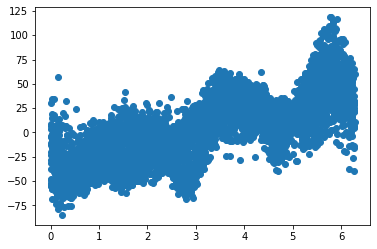

In [46]:
# for some reason the scale here is very off, so needs debugging

print("Linear Regression R^2:")
print(lm.score(rdm_minnie_sel_std, stim_intersect))
plt.scatter(y=lm.predict(rdm_minnie_sel_std), x=stim_intersect)

0.19272265135623978


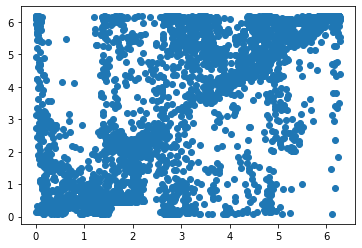

In [47]:
print(mlp.score(rdm_minnie_sel_std, stim_intersect))
plt.scatter(y=mlp.predict(rdm_minnie_sel_std), x=stim_intersect)

Plot MDS dimensions of RDMs

In [12]:
from sklearn import manifold
#from sklearn.metrics import euclidean_distances
seed=123
mds = manifold.MDS(n_components=2, max_iter=10000, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)


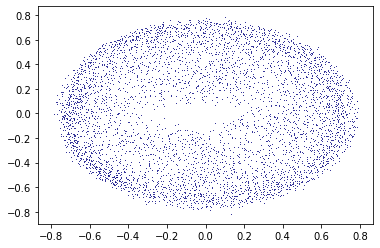

In [13]:
# Plot MDS of static data
pos_static = mds.fit(rdm_static_sel).embedding_
plt.scatter(pos_static[:, 0], pos_static[:, 1], color='navy', s=1, lw=0, label='Static')

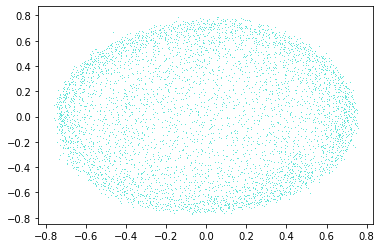

In [14]:
# Plot MDS of minnie mouse data
pos_minnie = mds.fit(rdm_minnie_sel).embedding_
plt.scatter(pos_minnie[:, 0], pos_minnie[:, 1], color='turquoise', s=1, lw=0, label='Minnie')

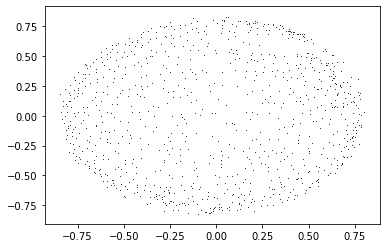

In [22]:
# Plot MDS of spontaneous data
pos_spont = mds.fit(rdm_spont_static).embedding_
plt.scatter(pos_spont[:, 0], pos_spont[:, 1], color='black', s=1, lw=0, label='spont')